In [1]:
import sys
sys.path.insert(1, '../../ana_tools')
import getters, tools, graphic_tools, setters
import matplotlib.pyplot as plt
plt.style.use('../../ana_tools/presentation.mplstyle')
import numpy as np
path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
plateaus = getters.get_plateaus()
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
import gc
gc.enable()
from scipy.optimize import curve_fit

/eos/home-i01/j/jcapotor/SWAN_projects/FBG_TMS
/eos/home-i01/j/jcapotor/SWAN_projects/FBG_TMS/ana_tools/plateaus.json


In [2]:
def line(x,a,b):
    return a+b*x

## 20230321 ##
# Description of the run #

* This run is a *temperature profile* run. It has 4 plateaus of 4 hour long each and a total elapsed time of 22h.
* It has only one fibre connected, *FBG2*, containing 4 sensors and coating type *ORMOCER*

The first thing to do is to get the objective temperature and humidity thta the climatic chamber was trying to follow and out of that obtain the initial and final times of each of the plateaus. *This task has been performed prior to teh start of this study*

In [3]:
date = "20230321"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)

Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  5.55it/s]


Keys to read: ['Temp1', 'Temp2']


Reading temperature key: Temp: 100%|██████████| 2/2 [00:00<00:00, 24.22it/s]


Keys to read: ['Hum1', 'Hum2']


Reading humidity key: Hum: 100%|██████████| 2/2 [00:00<00:00, 39.39it/s]


[789.97961161  13.17630549]
[795.23838817  13.26387928]
[794.70503665  13.25531454]
[796.98195558  13.29295833]


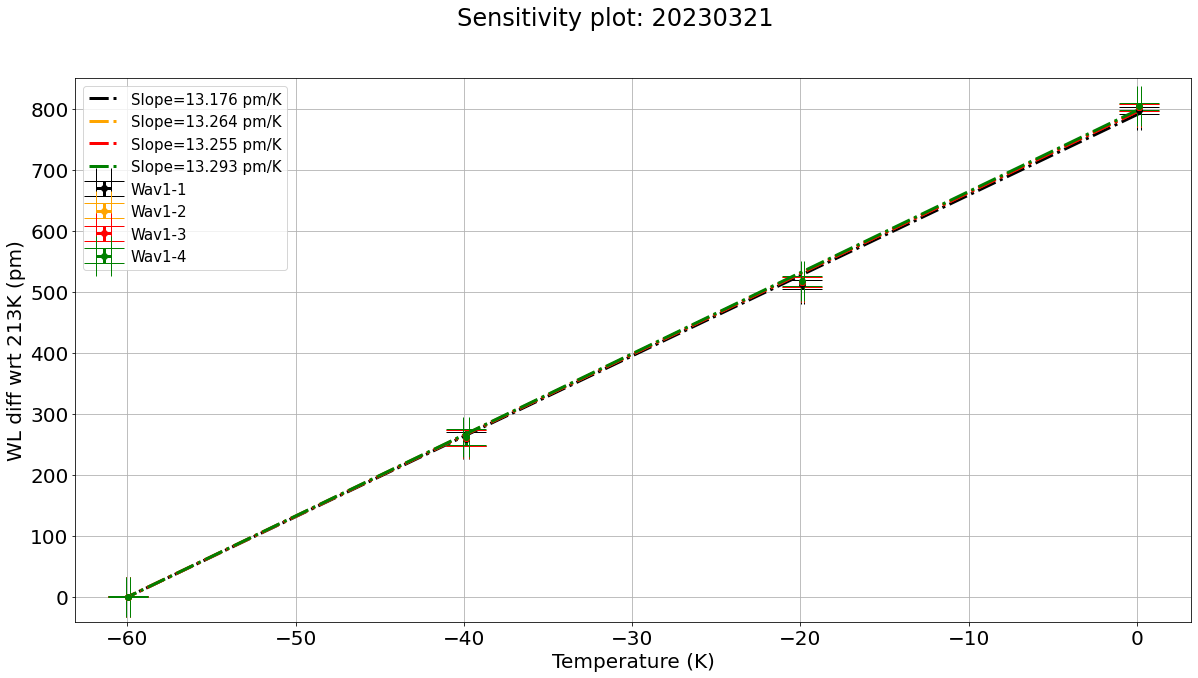

In [4]:
def plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes):
    fig.set_size_inches(20, 10)
    fig.suptitle("Sensitivity plot: " + date)
    t0 = plateaus[date]["213_down"][0]
    tf = plateaus[date]["213_down"][1]
    p0 = np.mean(peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)][sens])
    temps, wls, hums = [], [], []
    temps_err, wls_err, hums_err = [], [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0]
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        pcut = peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)]
        hcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0)&(climatic_chamber["Timestamp"]<tf)]
        
        temps.append(np.mean(hcut["T"]))
        wls.append(1e12*np.mean(pcut[sens]-p0))
        temps_err.append(np.std(hcut["T"]))
        wls_err.append(1e12*np.std(pcut[sens]-p0))
        hums.append(np.mean(hcut["RH"]))
        hums_err.append(np.std(hcut["RH"]))
    axes.errorbar(
        temps,
        wls,
        xerr=temps_err,
        yerr=wls_err,
        fmt="o",
        label=sens,
        capsize=20,
        color=colors[sens]
    )
    axes.set_xlabel("Temperature (K)")
    axes.set_ylabel("WL diff wrt 213K (pm)")
    popt,pcov = curve_fit(line, xdata=temps, ydata=wls, sigma=wls_err)
    print(popt)
    axes.plot(
        temps,
        line(np.array(temps), popt[0], popt[1]),
        label=r"Slope={0:.3f} pm/K".format(popt[1]),
        color=colors[sens],
        linestyle="-."
    )
    axes.legend(fontsize=15)
    return temps, hums, wls, popt
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 21.76it/s]


[767.2460732   12.83870858]
[772.8930922   12.94760366]
[771.28338795  12.91331304]
[776.26654067  13.00028798]


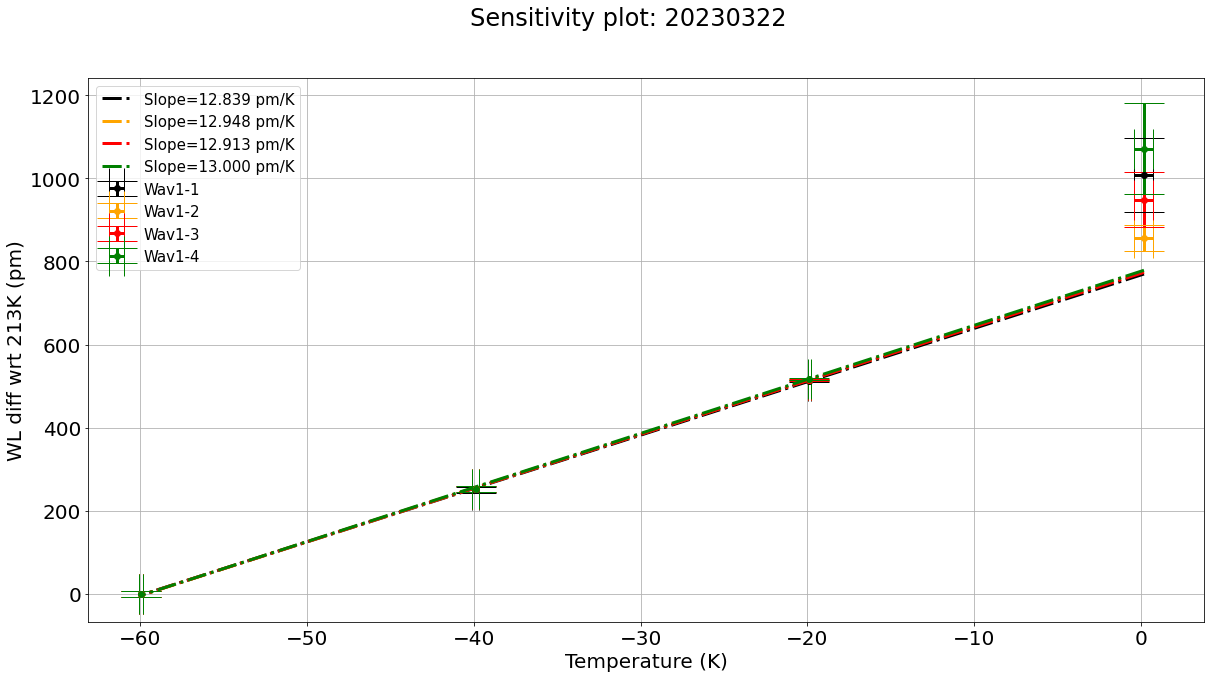

In [5]:
date = "20230322"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 25.16it/s]


[821.1502196   13.81018361]
[821.18470709  13.80918469]
[823.32615517  13.84440436]
[827.39258382  13.91148784]
[793.66442278  13.42404364]
[796.83918133  13.486848  ]
[800.63258342  13.54978419]
[802.59040626  13.59361122]


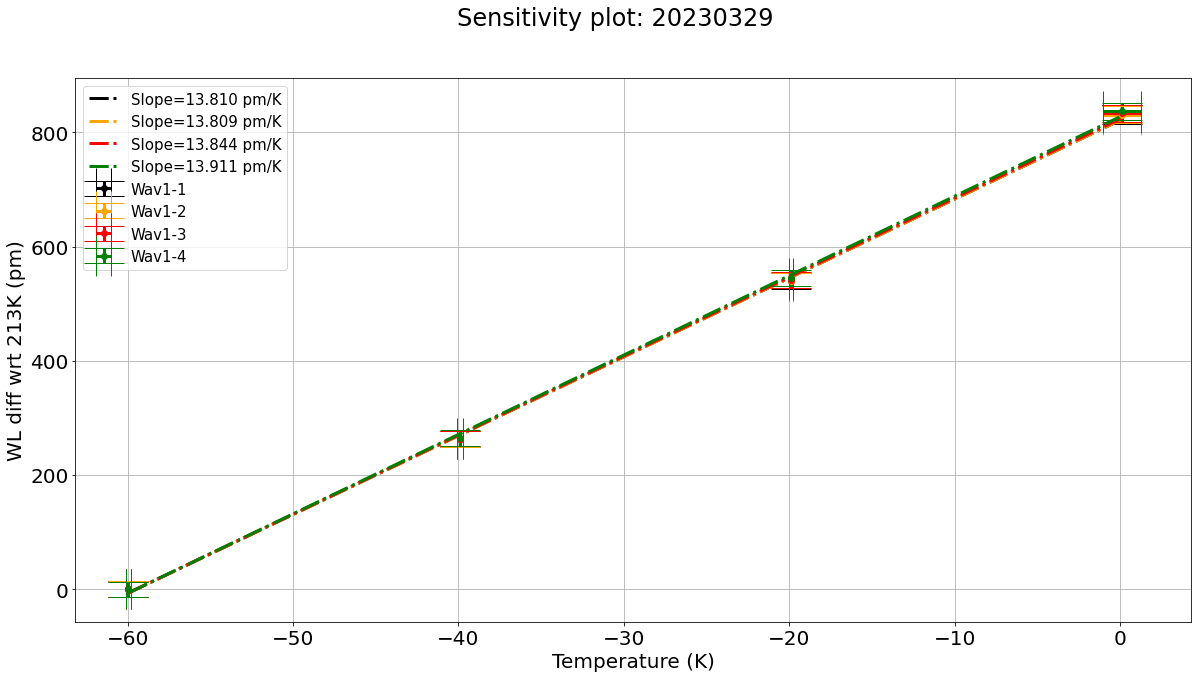

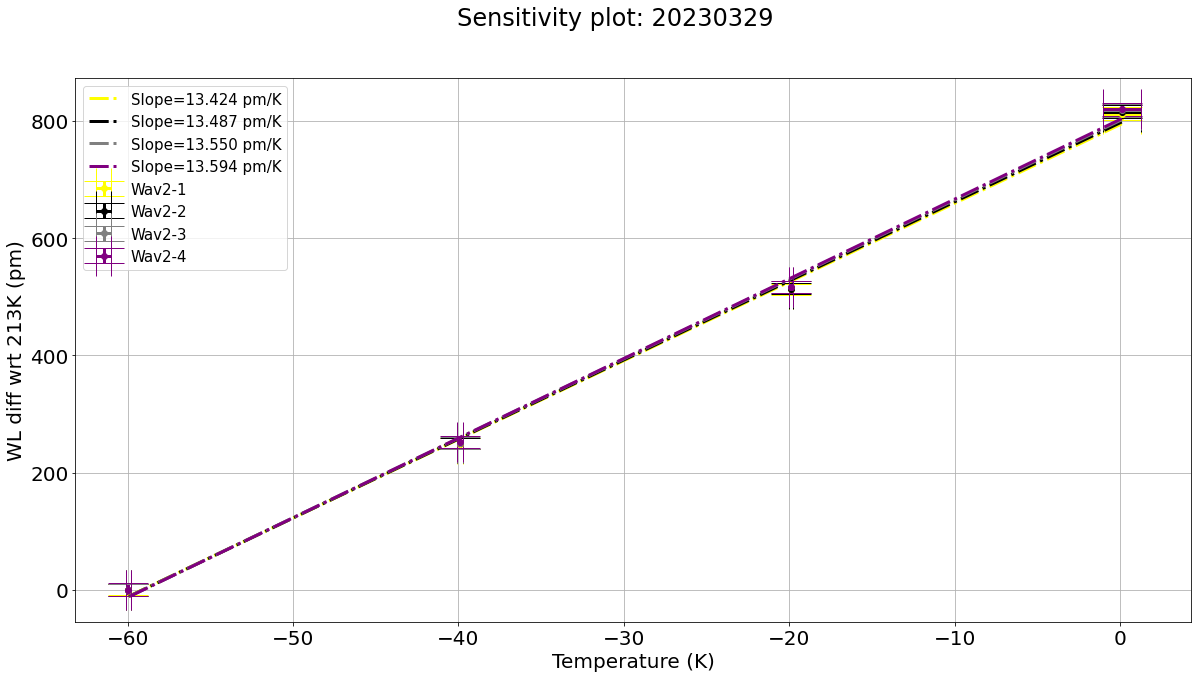

In [6]:
date = "20230329"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav2-1", "Wav2-2", "Wav2-3", "Wav2-4"]:
    plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:27<00:00,  1.64s/it]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 21.67it/s]


[89.38067966 -1.45025536]
[58.00328275 -0.94320428]
[66.22375697 -1.05782917]
[88.92205185 -1.43361487]


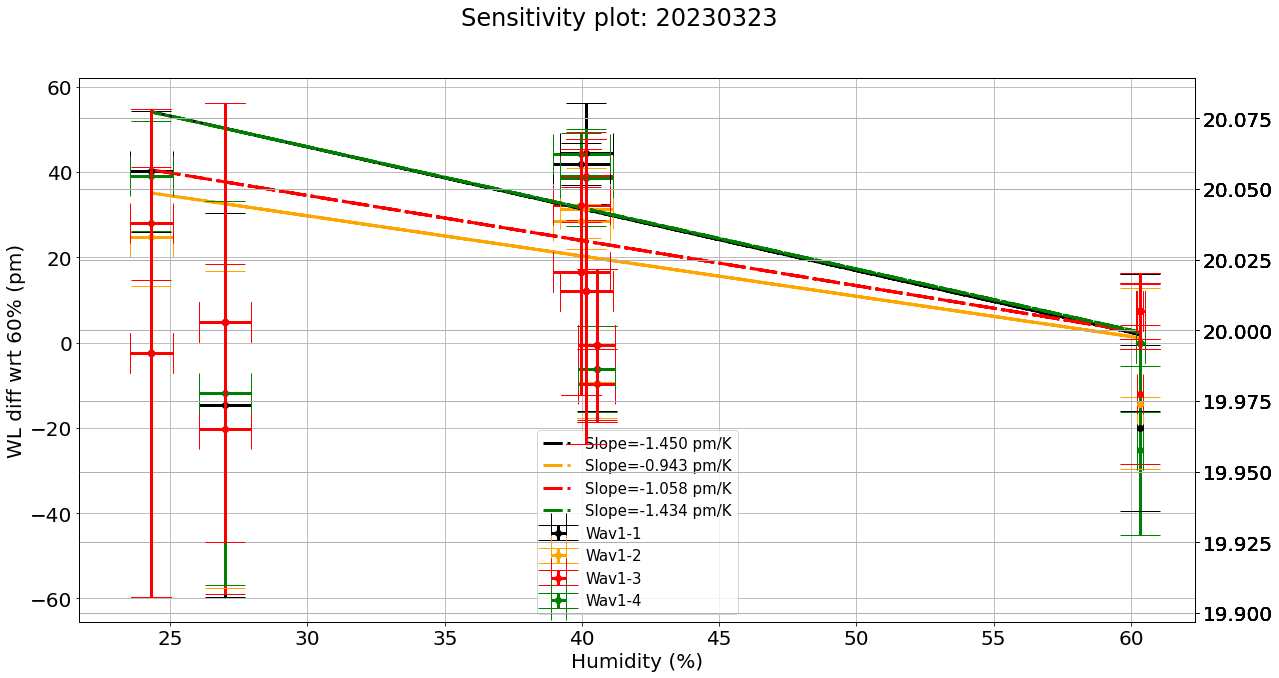

In [7]:
date = "20230323"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
def plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes):
    twin_axes = axes.twinx()
    fig.set_size_inches(20, 10)
    fig.suptitle("Sensitivity plot: " + date)
    t0 = plateaus[date]["60_up"][0]
    tf = plateaus[date]["60_up"][1]
    p0 = np.mean(peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)][sens])
    temps, wls, hums = [], [], []
    temps_err, wls_err, hums_err = [], [], []
    for plateau in plateaus[date]:
        t0 = plateaus[date][plateau][0]
        tf = plateaus[date][plateau][1]
        tcut = rtds.loc[(rtds["Timestamp"]>t0)&(rtds["Timestamp"]<tf)]
        pcut = peaks.loc[(peaks["Timestamp"]>t0)&(peaks["Timestamp"]<tf)]
        hcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0)&(climatic_chamber["Timestamp"]<tf)]
        
        temps.append(np.mean(hcut["T"]))
        wls.append(1e12*np.mean(pcut[sens]-p0))
        temps_err.append(np.std(hcut["T"]))
        wls_err.append(1e12*np.std(pcut[sens]-p0))
        hums.append(np.mean(hcut["RH"]))
        hums_err.append(np.std(hcut["RH"]))
    axes.errorbar(
        hums,
        wls,
        xerr=hums_err,
        yerr=wls_err,
        fmt="o",
        label=sens,
        capsize=20,
        color=colors[sens]
    )
    twin_axes.errorbar(
        hums,
        temps,
        xerr=hums_err,
        yerr=temps_err,
        fmt="o",
        label="Temperature",
        capsize=20,
        color="red"
    )
    axes.set_xlabel("Humidity (%)")
    axes.set_ylabel("WL diff wrt 60% (pm)")
    twin_axes.set_xlabel("Temperature (K)")
    popt,pcov = curve_fit(line, xdata=hums, ydata=wls, sigma=wls_err)
    print(popt)
    axes.plot(
        hums,
        line(np.array(hums), popt[0], popt[1]),
        label=r"Slope={0:.3f} pm/K".format(popt[1]),
        color=colors[sens],
        linestyle="-."
    )
    axes.legend(fontsize=15)
    return temps, hums, wls, popt
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 11.33it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


[131.49640754  -2.27598641]
[93.72296612 -1.64152723]
[98.52254907 -1.72299313]
[129.55504778  -2.21062568]


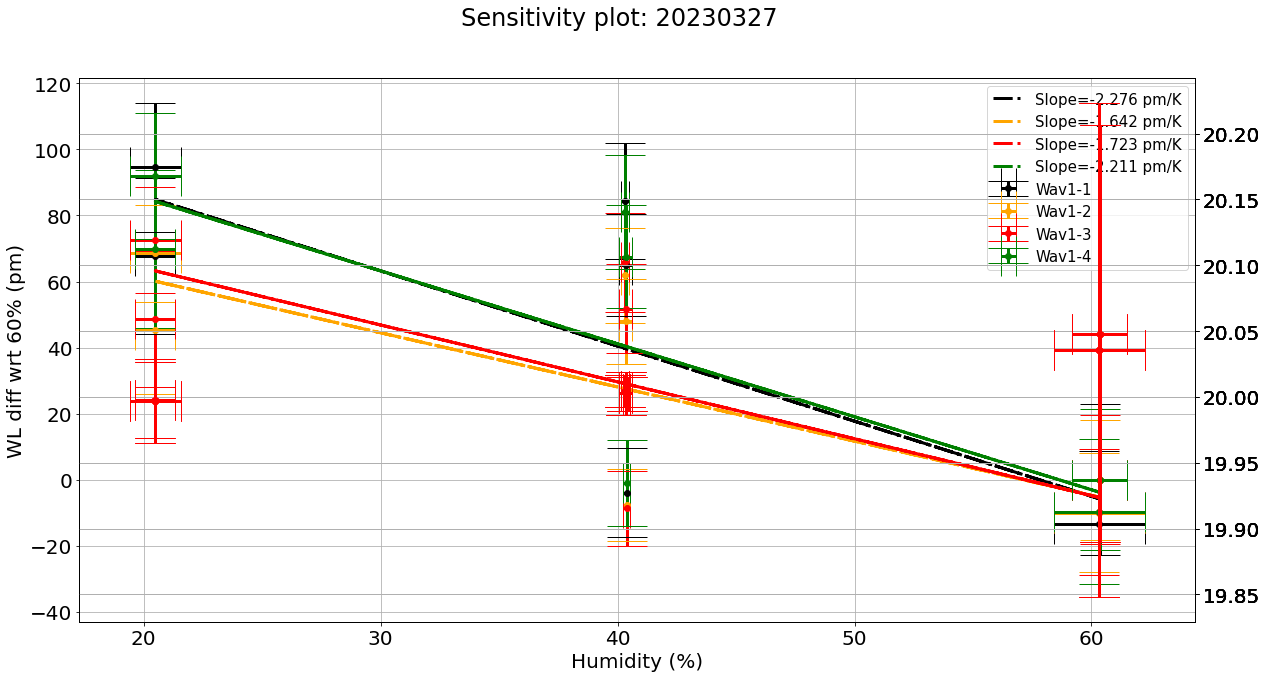

In [8]:
date = "20230327"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [01:09<00:00,  3.86s/it]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 28.35it/s]


[ 4.29625611 -0.08483957]
[-6.96847546  0.11218693]
[-10.08875808   0.16931741]
[-10.65647853   0.18150905]
[-86.66318325   1.38731531]
[-93.67334753   1.49897674]
[-98.4473885    1.57864773]
[-97.52933626   1.57083221]


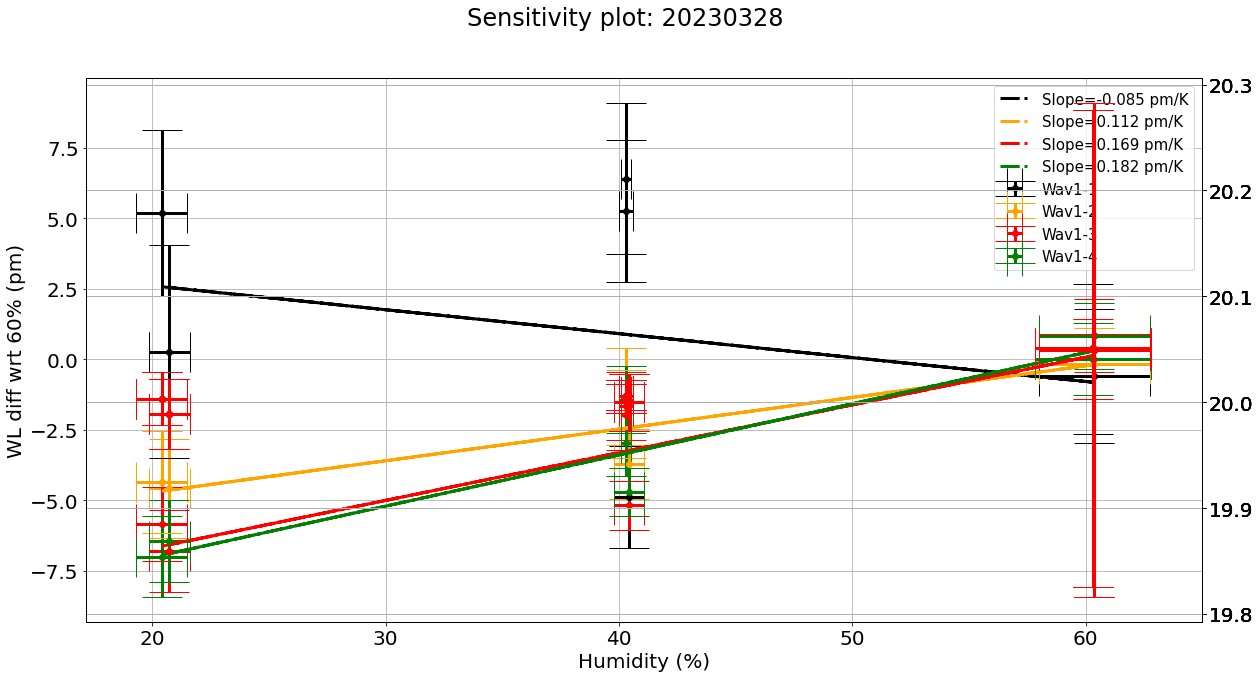

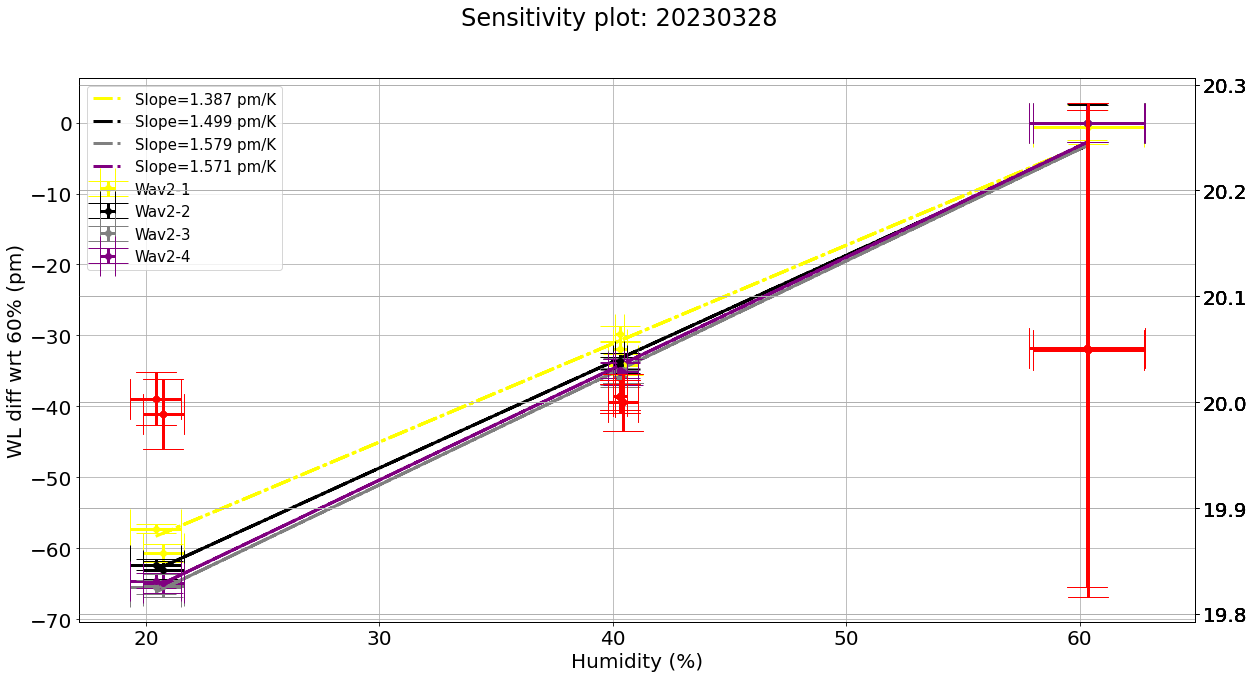

In [9]:
date = "20230328"
peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav1-1", "Wav1-2", "Wav1-3", "Wav1-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

fig, axes = plt.subplots(nrows=1, ncols=1)
for sens in ["Wav2-1", "Wav2-2", "Wav2-3", "Wav2-4"]:
    plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)

Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Keys to read: ['Temp1', 'Temp2']


Reading temperature key: Temp: 100%|██████████| 2/2 [00:00<00:00, 49.62it/s]


Keys to read: ['Hum1', 'Hum2']


Reading humidity key: Hum: 100%|██████████| 2/2 [00:00<00:00, 61.61it/s]


[789.97961161  13.17630549]
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:03<00:00,  5.64it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 58.68it/s]


[767.2460732   12.83870858]
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 25.66it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 47.10it/s]


[821.1502196   13.81018361]


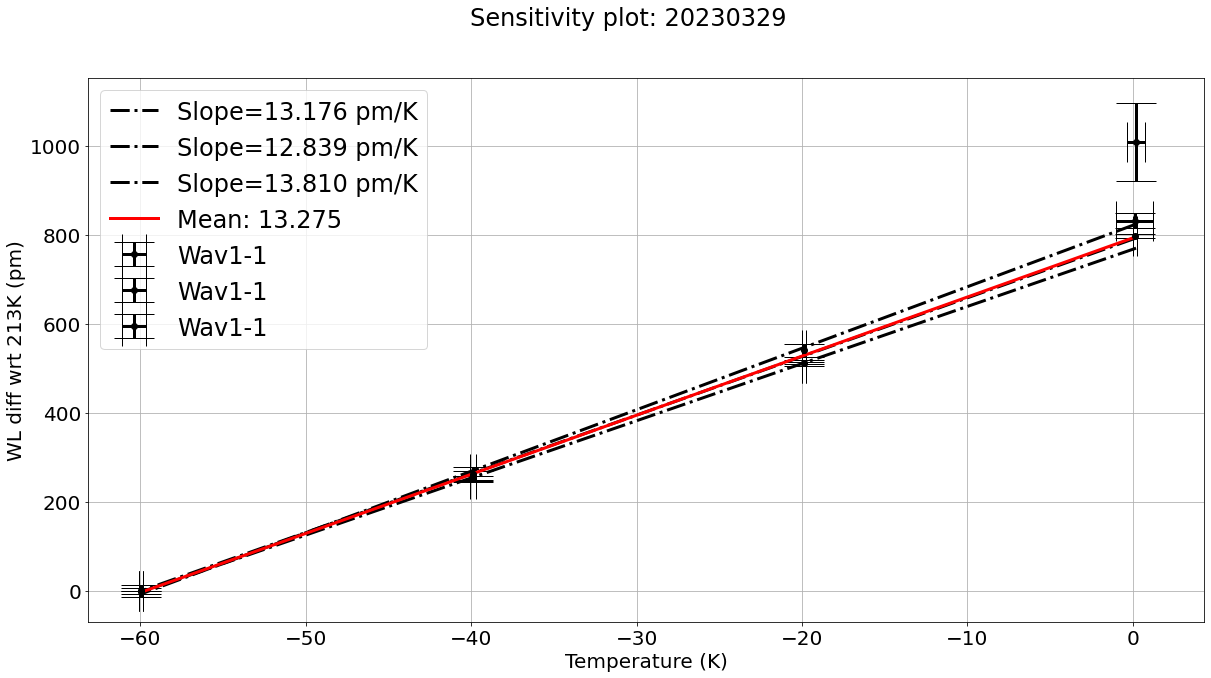

In [10]:
tdates = ["20230321", "20230322", "20230329"]
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
fig, axes = plt.subplots(nrows=1, ncols=1)
popts = []
T0 = []
for date in tdates:
    peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
    rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
    for sens in ["Wav1-1"]:
        temps, hums, wls, popt = plot_sensitivity_temp(date, peaks, rtds, climatic_chamber, sens, axes)
        popts.append(popt[1])
        T0.append(popt[0])
axes.plot(temps, line(np.array(temps), np.mean(T0), np.mean(popts)),
          color="red", label=r"Mean: {0:.3f}".format(np.mean(popts)))
axes.legend()

Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:02<00:00,  5.90it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 57.46it/s]


[89.38067966 -1.45025536]
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:05<00:00,  4.23it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 59.41it/s]


[131.49640754  -2.27598641]
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:05<00:00,  3.03it/s]


Keys to read: ['Temp1']


Reading temperature key: Temp: 100%|██████████| 1/1 [00:00<00:00, 31.88it/s]


Keys to read: ['Hum1']


Reading humidity key: Hum: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]


[ 4.29625611 -0.08483957]


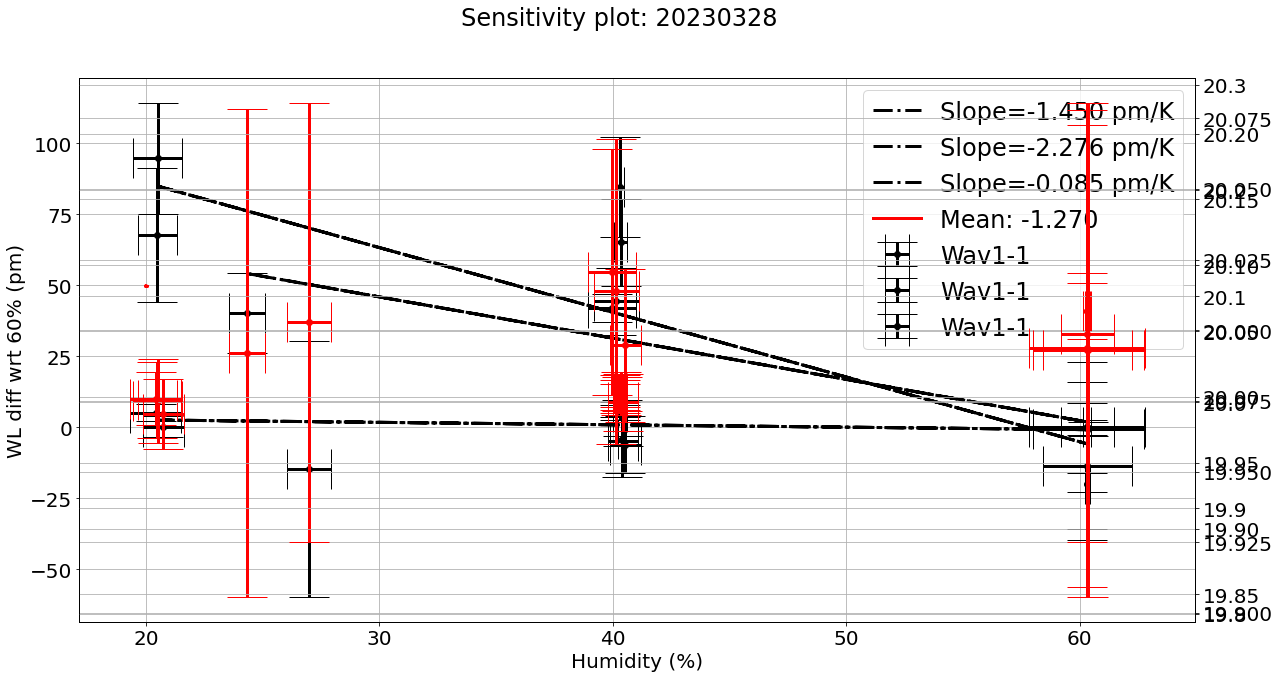

In [11]:
hdates = ["20230323", "20230327", "20230328"]
colors = {"Wav1-1":"black", "Wav1-2":"orange", "Wav1-3":"red", "Wav1-4":"green",
          "Wav2-1":"yellow", "Wav2-2":"black", "Wav2-3":"grey", "Wav2-4":"purple", "Wav2-5":"darkred"}
fig, axes = plt.subplots(nrows=1, ncols=1)
popts = []
T0 = []
for date in hdates:
    peaks = getters.get_raw_data(path_to_split=path+date+"/", filetype="peaks", pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
    rtds = getters.get_raw_data(path_to_split=path+date+"/", filetype="temperature", pol="Temp").sort_values(by="Timestamp").reset_index(drop=True)
    climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/", filetype="humidity", pol="Hum").sort_values(by="Timestamp").reset_index(drop=True)
    for sens in ["Wav1-1"]:
        temps, hums, wls, popt = plot_sensitivity_hum(date, peaks, rtds, climatic_chamber, sens, axes)
        popts.append(popt[1])
        T0.append(popt[0])
axes.plot(temps, line(np.array(temps), np.mean(T0), np.mean(popts)),
          color="red", label=r"Mean: {0:.3f}".format(np.mean(popts)))
axes.legend()

In [3]:
def pol(x, A, B, C, D):
    return A + B*x + C*x**2 + D*x**3

20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:13<00:00,  1.75it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:05<00:00,  2.42it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


20230321
Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  5.82it/s]


20230322
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:04<00:00,  4.57it/s]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Wav1-1 : A=-5330.736 pm, B=24.083 pm/K
Wav1-1 : A=-181120.973 pm, B=2281.125 pm/K, C=-9.588 pm/$K^2$, D=0.013 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:11<00:00,  2.03it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:10<00:00,  2.16it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


20230321
Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  6.36it/s]


20230322
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.80it/s]


Wav1-2 : A=-5151.525 pm, B=23.323 pm/K
Wav1-2 : A=-157601.138 pm, B=1984.285 pm/K, C=-8.344 pm/$K^2$, D=0.012 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:12<00:00,  1.77it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:10<00:00,  2.12it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


20230321
Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  6.24it/s]


20230322
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]


Wav1-3 : A=-5270.727 pm, B=23.841 pm/K
Wav1-3 : A=-150843.250 pm, B=1904.221 pm/K, C=-8.032 pm/$K^2$, D=0.011 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:11<00:00,  2.03it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:21<00:00,  1.30s/it]


20230321
Keys to read: ['10Av1', '11Av1', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av1', '5Av2', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 16/16 [00:02<00:00,  5.87it/s]


20230322
Keys to read: ['10Av3', '1Av1', '1Av2', '1Av3', '1Av4', '2Av1', '2Av3', '2Av4', '3Av1', '3Av3', '3Av4', '4Av1', '4Av3', '4Av4', '5Av3', '5Av4', '6Av3', '7Av3', '8Av3', '9Av3']


Reading peaks key: Av: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]


Wav1-4 : A=-5246.598 pm, B=23.727 pm/K
Wav1-4 : A=-177106.844 pm, B=2228.535 pm/K, C=-9.360 pm/$K^2$, D=0.013 pm/$K^3$


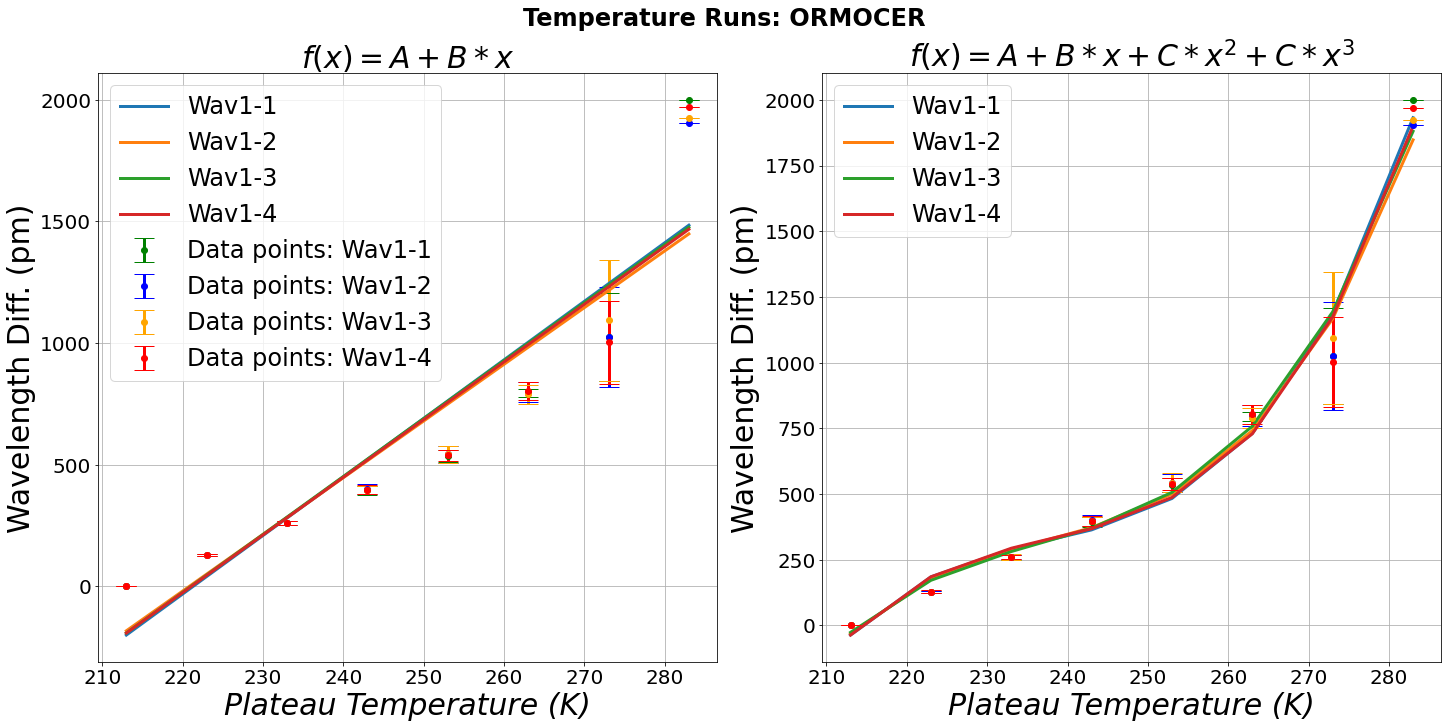

In [17]:
tdates = ["20230221", "20230222", "20230223", "20230224", "20230321", "20230322", "20230329"]
colors = {"1":"green", "2":"blue", "3":"orange", "4":"red"}
off_teo = {"2":5000, "3":10000, "4":15000}
fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
fig.suptitle("Temperature Runs: ORMOCER", fontweight="bold")
fig.set_size_inches((20,10))
tau = 6000
#Creating a dictionary that will contain the accuracies and humidities for each of the plateaus
for nsens in ["1", "2", "3", "4"]:
    TEMPS, HUMS = {}, {}
    TEMPS_ERR, HUMS_ERR = {}, {}
    for key in plateaus["20230224"].keys():
        if "293" in key:
            continue
        if str(key.split("_")[1]) == "up":
            continue
        TEMPS[str(key.split("_")[0])] = []
        HUMS[str(key.split("_")[0])] = []
        TEMPS_ERR[str(key.split("_")[0])] = []
        HUMS_ERR[str(key.split("_")[0])] = []

    for date in tdates:
        print(date)
        if "202302" in date:
            sens="Wav2-"+nsens
            ref="Wav2-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
        if "202303" in date:
            sens="Wav1-"+nsens
            ref="Wav1-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
        climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/",
                                                filetype="peaks",
                                                pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
        t0 = plateaus[date]["213_down"][0]
        tf = plateaus[date]["213_down"][1]
        tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
        ref_val = np.mean((tcut[sens]).values)
        for plateau in plateaus[date]:
            t0 = plateaus[date][plateau][0]
            tf = plateaus[date][plateau][1]
            temp = plateau.split("_")[0]
            tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
            if len(tcut) < 1000:
                continue
            TEMPS[temp].append(np.mean((tcut[sens]-ref_val).values))
            TEMPS_ERR[temp].append(np.std((tcut[sens]-ref_val).values))

    accuracies, accuracies_err = [], []
    accuracies_stab, accuracies_stab_err = [], []
    temperatures = []
    for temp in TEMPS.keys():
        temperatures.append(int(temp))
        accuracies.append(np.mean(TEMPS[temp]))
        accuracies_err.append(np.std(TEMPS[temp]))
        accuracies_stab.append(np.mean(TEMPS_ERR[temp]))
        accuracies_stab_err.append(np.std(TEMPS_ERR[temp]))

    axes[0].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    label=r"Data points: Wav1-{}".format(nsens))
    axes[1].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    )
    popt, pcov = curve_fit(line, np.array(temperatures), 1e12*np.array(accuracies))
    axes[0].plot(temperatures,
              line(np.array(temperatures), popt[0], popt[1]),
              label=r"Wav1-{0}".format(nsens))
    print(r"Wav1-{0} : A={1:.3f} pm, B={2:.3f} pm/K".format(nsens, popt[0], popt[1]))
    popt, pcov = curve_fit(pol, np.array(temperatures), 1e12*np.array(accuracies))
    axes[1].plot(temperatures,
              pol(np.array(temperatures), popt[0], popt[1], popt[2], popt[3]),
              label=r"Wav1-{0}".format(nsens))
    print(r"Wav1-{0} : A={1:.3f} pm, B={2:.3f} pm/K, C={3:.3f} pm/$K^2$, D={4:.3f} pm/$K^3$".format(nsens, popt[0], popt[1], popt[2], popt[3]))
    axes[0].legend()
    axes[0].set_title(r"$f(x) = A + B*x$", fontsize=30, fontweight="bold")
    axes[0].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[0].set_xlabel("Plateau Temperature (K)", fontsize=30, style="italic")
    axes[1].legend()
    axes[1].set_title(r"$f(x)=A + B*x + C*x^2 + C*x^3$", fontsize=30, fontweight="bold")
    axes[1].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[1].set_xlabel("Plateau Temperature (K)", fontsize=30, style="italic")    

20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:12<00:00,  1.92it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:05<00:00,  2.48it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.63it/s]


Wav2-1 : A=-6194.482 pm, B=27.872 pm/K
Wav2-1 : A=-181988.581 pm, B=2309.677 pm/K, C=-9.789 pm/$K^2$, D=0.014 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:14<00:00,  1.59it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:14<00:00,  1.63it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:43<00:00,  1.64s/it]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s]


Wav2-2 : A=-5356.169 pm, B=24.239 pm/K
Wav2-2 : A=-146167.207 pm, B=1846.582 pm/K, C=-7.797 pm/$K^2$, D=0.011 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:12<00:00,  1.82it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s]


Wav2-3 : A=-5279.415 pm, B=23.903 pm/K
Wav2-3 : A=-145950.203 pm, B=1842.089 pm/K, C=-7.770 pm/$K^2$, D=0.011 pm/$K^3$
20230221
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:14<00:00,  1.64it/s]


20230222
Keys to read: ['10Av2', '1Av1', '1Av2', '1Av3', '2Av1', '2Av2', '2Av3', '3Av1', '3Av2', '3Av3', '4Av1', '4Av2', '4Av3', '5Av1', '5Av2', '5Av3', '6Av1', '6Av2', '6Av3', '7Av1', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 23/23 [00:12<00:00,  1.81it/s]


20230223
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


20230224
Keys to read: ['10Av2', '10Av3', '10Av4', '11Av2', '11Av3', '11Av4', '12Av2', '12Av3', '12Av4', '13Av2', '13Av3', '13Av4', '14Av2', '14Av3', '14Av4', '15Av2', '15Av3', '15Av4', '16Av2', '16Av3', '16Av4', '17Av2', '17Av3', '17Av4', '18Av2', '18Av3', '18Av4', '19Av2', '19Av3', '19Av4', '1Av1', '1Av2', '1Av3', '1Av4', '20Av2', '20Av3', '20Av4', '21Av2', '21Av4', '2Av2', '2Av3', '2Av4', '3Av2', '3Av3', '3Av4', '4Av2', '4Av3', '4Av4', '5Av2', '5Av3', '5Av4', '6Av2', '6Av3', '6Av4', '7Av2', '7Av3', '7Av4', '8Av2', '8Av3', '8Av4', '9Av2', '9Av3', '9Av4']


Reading peaks key: Av: 100%|██████████| 63/63 [01:29<00:00,  1.42s/it]


20230329
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '1Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 18/18 [00:06<00:00,  2.78it/s]


Wav2-4 : A=-5073.456 pm, B=22.993 pm/K
Wav2-4 : A=-171009.035 pm, B=2147.988 pm/K, C=-9.006 pm/$K^2$, D=0.013 pm/$K^3$


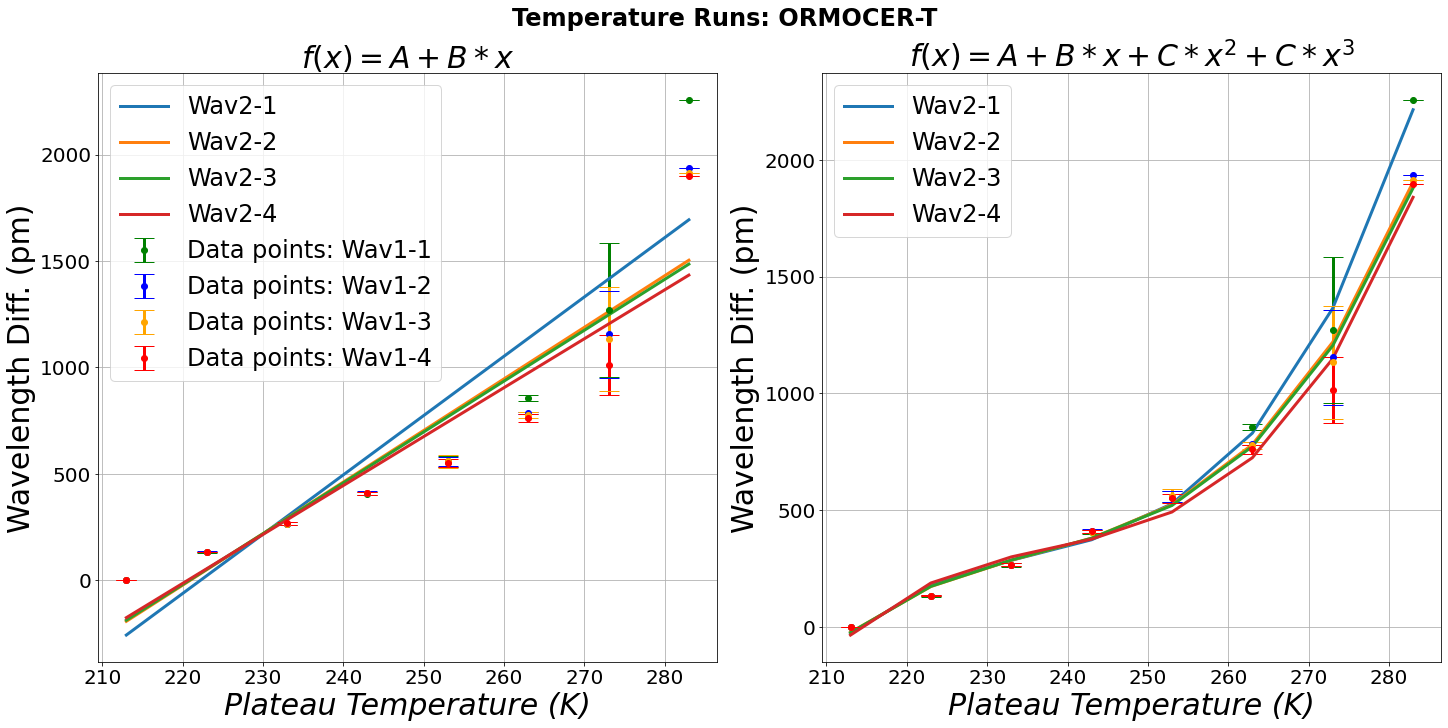

In [19]:
tdates = ["20230221", "20230222", "20230223", "20230224", "20230329"]
colors = {"1":"green", "2":"blue", "3":"orange", "4":"red"}
off_teo = {"2":5000, "3":10000, "4":15000}
fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
fig.suptitle("Temperature Runs: ORMOCER-T", fontweight="bold")
fig.set_size_inches((20,10))
tau = 6000
#Creating a dictionary that will contain the accuracies and humidities for each of the plateaus
for nsens in ["1", "2", "3", "4"]:
    TEMPS, HUMS = {}, {}
    TEMPS_ERR, HUMS_ERR = {}, {}
    for key in plateaus["20230224"].keys():
        if "293" in key:
            continue
        if str(key.split("_")[1]) == "up":
            continue
        TEMPS[str(key.split("_")[0])] = []
        HUMS[str(key.split("_")[0])] = []
        TEMPS_ERR[str(key.split("_")[0])] = []
        HUMS_ERR[str(key.split("_")[0])] = []

    for date in tdates:
        print(date)
        if "202302" in date:
            sens="Wav1-"+nsens
            ref="Wav1-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
        if "202303" in date:
            sens="Wav2-"+nsens
            ref="Wav2-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
        climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/",
                                                filetype="peaks",
                                                pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
        t0 = plateaus[date]["213_down"][0]
        tf = plateaus[date]["213_down"][1]
        tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
        ref_val = np.mean((tcut[sens]).values)
        for plateau in plateaus[date]:
            t0 = plateaus[date][plateau][0]
            tf = plateaus[date][plateau][1]
            temp = plateau.split("_")[0]
            tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
            if len(tcut) < 1000:
                continue
            TEMPS[temp].append(np.mean((tcut[sens]-ref_val).values))
            TEMPS_ERR[temp].append(np.std((tcut[sens]-ref_val).values))

    accuracies, accuracies_err = [], []
    accuracies_stab, accuracies_stab_err = [], []
    temperatures = []
    for temp in TEMPS.keys():
        temperatures.append(int(temp))
        accuracies.append(np.mean(TEMPS[temp]))
        accuracies_err.append(np.std(TEMPS[temp]))
        accuracies_stab.append(np.mean(TEMPS_ERR[temp]))
        accuracies_stab_err.append(np.std(TEMPS_ERR[temp]))

    axes[0].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    label=r"Data points: Wav1-{}".format(nsens))
    axes[1].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    )
    popt, pcov = curve_fit(line, np.array(temperatures), 1e12*np.array(accuracies))
    axes[0].plot(temperatures,
              line(np.array(temperatures), popt[0], popt[1]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K".format(nsens, popt[0], popt[1]))
    popt, pcov = curve_fit(pol, np.array(temperatures), 1e12*np.array(accuracies))
    axes[1].plot(temperatures,
              pol(np.array(temperatures), popt[0], popt[1], popt[2], popt[3]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K, C={3:.3f} pm/$K^2$, D={4:.3f} pm/$K^3$".format(nsens, popt[0], popt[1], popt[2], popt[3]))
    axes[0].legend()
    axes[0].set_title(r"$f(x) = A + B*x$", fontsize=30, fontweight="bold")
    axes[0].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[0].set_xlabel("Plateau Temperature (K)", fontsize=30, style="italic")
    axes[1].legend()
    axes[1].set_title(r"$f(x)=A + B*x + C*x^2 + C*x^3$", fontsize=30, fontweight="bold")
    axes[1].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[1].set_xlabel("Plateau Temperature (K)", fontsize=30, style="italic")    

In [5]:
def pol(x, A, B, C):
    return A + B*x + C*x**2

20230323
Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:02<00:00,  7.30it/s]


20230327
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s]


20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Wav2-1 : A=32.450 pm, B=-1.633 pm/K
[inf inf inf]
Wav2-1 : A=11.227 pm, B=-0.202 pm/K, C=-0.020 pm/$K^2$
[inf inf inf]
20230323
Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


20230327
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s]


20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:03<00:00,  4.98it/s]


Wav2-2 : A=22.219 pm, B=-1.101 pm/K
[inf inf inf]
Wav2-2 : A=7.910 pm, B=-0.134 pm/K, C=-0.013 pm/$K^2$
[inf inf inf]
20230323


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:01<00:00,  9.85it/s]


20230327
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:03<00:00,  7.57it/s]


20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:03<00:00,  5.27it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Wav2-3 : A=24.011 pm, B=-1.160 pm/K
[inf inf inf]
Wav2-3 : A=8.147 pm, B=-0.092 pm/K, C=-0.015 pm/$K^2$
[inf inf inf]
20230323
Keys to read: ['10Av0', '11Av0', '12Av0', '13Av0', '14Av0', '15Av0', '16Av0', '17Av0', '1Av0', '2Av0', '3Av0', '4Av0', '5Av0', '6Av0', '7Av0', '8Av0', '9Av0']


Reading peaks key: Av: 100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


20230327
Keys to read: ['10Av1', '11Av1', '12Av1', '13Av1', '14Av1', '15Av1', '16Av1', '17Av1', '18Av1', '19Av1', '1Av1', '20Av1', '21Av1', '22Av1', '23Av1', '2Av1', '3Av1', '4Av1', '5Av1', '6Av1', '7Av1', '8Av1', '9Av1']


Reading peaks key: Av: 100%|██████████| 23/23 [00:04<00:00,  5.46it/s]


20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]


Wav2-4 : A=29.707 pm, B=-1.483 pm/K
[inf inf inf]
Wav2-4 : A=9.013 pm, B=-0.065 pm/K, C=-0.020 pm/$K^2$
[inf inf inf]


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


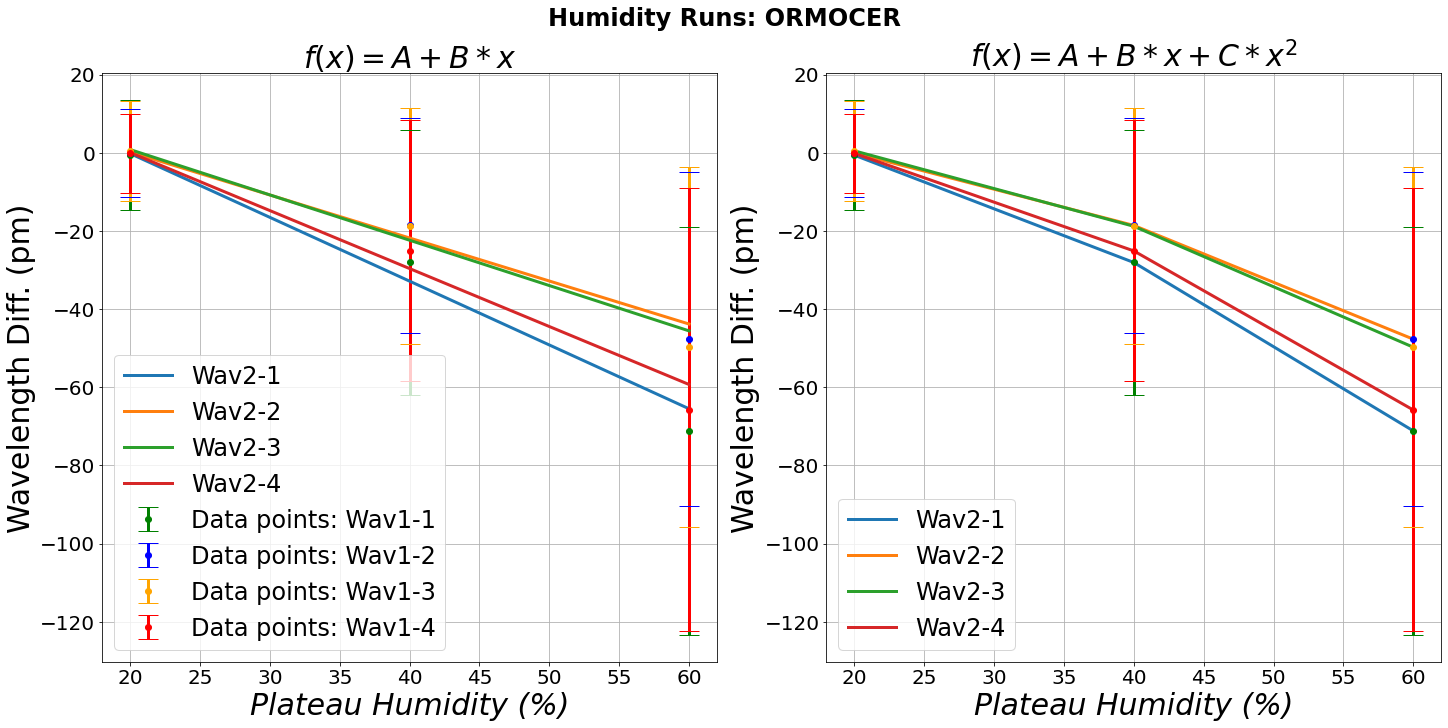

In [13]:
tdates = ["20230323", "20230327", "20230328"]
colors = {"1":"green", "2":"blue", "3":"orange", "4":"red"}
off_teo = {"2":5000, "3":10000, "4":15000}
fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
fig.suptitle("Humidity Runs: ORMOCER", fontweight="bold")
fig.set_size_inches((20,10))
tau = 6000
#Creating a dictionary that will contain the accuracies and humidities for each of the plateaus
for nsens in ["1", "2", "3", "4"]:
    TEMPS, HUMS = {}, {}
    TEMPS_ERR, HUMS_ERR = {}, {}
    for key in plateaus["20230323"].keys():
        TEMPS[str(key.split("_")[0])] = []
        HUMS[str(key.split("_")[0])] = []
        TEMPS_ERR[str(key.split("_")[0])] = []
        HUMS_ERR[str(key.split("_")[0])] = []

    for date in tdates:
        print(date)
        if "202302" in date:
            sens="Wav2-"+nsens
            ref="Wav2-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
        if "202303" in date:
            sens="Wav1-"+nsens
            ref="Wav1-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
        climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/",
                                                filetype="peaks",
                                                pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
        t0 = plateaus[date]["20_up"][0]
        tf = plateaus[date]["20_up"][1]
        tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
        ref_val = np.mean((tcut[sens]).values)
        for plateau in plateaus[date]:
            t0 = plateaus[date][plateau][0]
            tf = plateaus[date][plateau][1]
            temp = plateau.split("_")[0]
            tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
            if len(tcut) < 1000:
                continue
            TEMPS[temp].append(np.mean((tcut[sens]-ref_val).values))
            TEMPS_ERR[temp].append(np.std((tcut[sens]-ref_val).values))

    accuracies, accuracies_err = [], []
    accuracies_stab, accuracies_stab_err = [], []
    temperatures = []
    for temp in TEMPS.keys():
        temperatures.append(int(temp))
        accuracies.append(np.mean(TEMPS[temp]))
        accuracies_err.append(np.std(TEMPS[temp]))
        accuracies_stab.append(np.mean(TEMPS_ERR[temp]))
        accuracies_stab_err.append(np.std(TEMPS_ERR[temp]))

    axes[0].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    label=r"Data points: Wav1-{}".format(nsens))
    axes[1].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    )
    popt, pcov = curve_fit(line, np.array(temperatures), 1e12*np.array(accuracies), sigma=1e12*np.array(accuracies_err))
    axes[0].plot(temperatures,
              line(np.array(temperatures), popt[0], popt[1]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K".format(nsens, popt[0], popt[1]))
    popt, pcov = curve_fit(pol, np.array(temperatures), 1e12*np.array(accuracies))
    print(np.sqrt(np.diag(pcov)))
    axes[1].plot(temperatures,
              pol(np.array(temperatures), popt[0], popt[1], popt[2]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K, C={3:.3f} pm/$K^2$".format(nsens, popt[0], popt[1], popt[2]))
    print(np.sqrt(np.diag(pcov)))
    axes[0].legend()
    axes[0].set_title(r"$f(x) = A + B*x$", fontsize=30, fontweight="bold")
    axes[0].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[0].set_xlabel("Plateau Humidity (%)", fontsize=30, style="italic")
    axes[1].legend()
    axes[1].set_title(r"$f(x)=A + B*x + C*x^2$", fontsize=30, fontweight="bold")
    axes[1].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[1].set_xlabel("Plateau Humidity (%)", fontsize=30, style="italic")    

20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  3.76it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Wav2-1 : A=-31.468 pm, B=1.450 pm/K
[4.23311427 0.10572906]
Wav2-1 : A=-20.850 pm, B=0.806 pm/K, C=0.008 pm/$K^2$
[inf inf inf]
20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Wav2-2 : A=-28.930 pm, B=1.437 pm/K
[1.99470024 0.08606464]
Wav2-2 : A=-19.966 pm, B=0.790 pm/K, C=0.010 pm/$K^2$
[inf inf inf]
20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.04it/s]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Wav2-3 : A=-30.415 pm, B=1.527 pm/K
[2.1287675  0.07571326]
Wav2-3 : A=-22.295 pm, B=0.942 pm/K, C=0.009 pm/$K^2$
[inf inf inf]
20230328
Keys to read: ['10Av2', '11Av2', '12Av2', '13Av2', '14Av2', '1Av1', '1Av2', '2Av1', '2Av2', '3Av1', '3Av2', '4Av1', '4Av2', '5Av2', '6Av2', '7Av2', '8Av2', '9Av2']


Reading peaks key: Av: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]


Wav2-4 : A=-29.798 pm, B=1.492 pm/K
[0.83285708 0.03740094]
Wav2-4 : A=-22.467 pm, B=0.947 pm/K, C=0.009 pm/$K^2$
[inf inf inf]


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


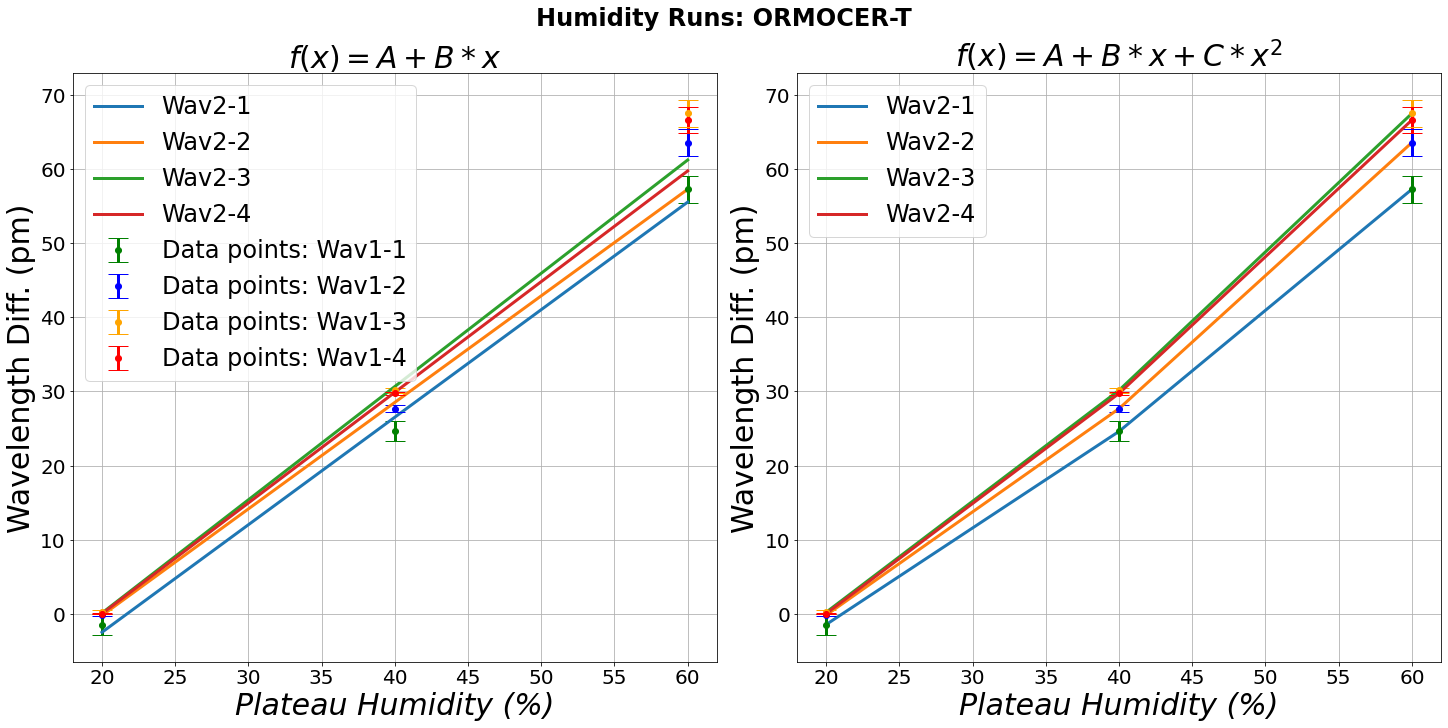

In [14]:
tdates = ["20230328"]
colors = {"1":"green", "2":"blue", "3":"orange", "4":"red"}
off_teo = {"2":5000, "3":10000, "4":15000}
fig, axes = graphic_tools.make_figure(ncols=2, nrows=1)
fig.suptitle("Humidity Runs: ORMOCER-T", fontweight="bold")
fig.set_size_inches((20,10))
tau = 6000
#Creating a dictionary that will contain the accuracies and humidities for each of the plateaus
for nsens in ["1", "2", "3", "4"]:
    TEMPS, HUMS = {}, {}
    TEMPS_ERR, HUMS_ERR = {}, {}
    for key in plateaus["20230328"].keys():
        TEMPS[str(key.split("_")[0])] = []
        HUMS[str(key.split("_")[0])] = []
        TEMPS_ERR[str(key.split("_")[0])] = []
        HUMS_ERR[str(key.split("_")[0])] = []

    for date in tdates:
        print(date)
        if "202302" in date:
            sens="Wav1-"+nsens
            ref="Wav1-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/FebruaryRuns/"
        if "202303" in date:
            sens="Wav2-"+nsens
            ref="Wav2-1"
            path = "/eos/user/j/jcapotor/FBGana/camara_climatica/MarchRuns/"
        climatic_chamber = getters.get_raw_data(path_to_split=path+date+"/",
                                                filetype="peaks",
                                                pol="Av").sort_values(by="Timestamp").reset_index(drop=True)
        t0 = plateaus[date]["20_up"][0]
        tf = plateaus[date]["20_up"][1]
        tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
        ref_val = np.mean((tcut[sens]).values)
        for plateau in plateaus[date]:
            t0 = plateaus[date][plateau][0]
            tf = plateaus[date][plateau][1]
            temp = plateau.split("_")[0]
            tcut = climatic_chamber.loc[(climatic_chamber["Timestamp"]>t0+tau)&(climatic_chamber["Timestamp"]<tf)]
            if len(tcut) < 1000:
                continue
            TEMPS[temp].append(np.mean((tcut[sens]-ref_val).values))
            TEMPS_ERR[temp].append(np.std((tcut[sens]-ref_val).values))

    accuracies, accuracies_err = [], []
    accuracies_stab, accuracies_stab_err = [], []
    temperatures = []
    for temp in TEMPS.keys():
        temperatures.append(int(temp))
        accuracies.append(np.mean(TEMPS[temp]))
        accuracies_err.append(np.std(TEMPS[temp]))
        accuracies_stab.append(np.mean(TEMPS_ERR[temp]))
        accuracies_stab_err.append(np.std(TEMPS_ERR[temp]))

    axes[0].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    label=r"Data points: Wav1-{}".format(nsens))
    axes[1].errorbar(temperatures, 1e12*np.array(accuracies), fmt="o", capsize=10,
                          yerr=1e12*np.array(accuracies_err), color=colors[nsens],
                    )
    popt, pcov = curve_fit(line, np.array(temperatures), 1e12*np.array(accuracies), sigma=1e12*np.array(accuracies_err))
    axes[0].plot(temperatures,
              line(np.array(temperatures), popt[0], popt[1]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K".format(nsens, popt[0], popt[1]))
    print(np.sqrt(np.diag(pcov)))
    popt, pcov = curve_fit(pol, np.array(temperatures), 1e12*np.array(accuracies))
    axes[1].plot(temperatures,
              pol(np.array(temperatures), popt[0], popt[1], popt[2]),
              label=r"Wav2-{0}".format(nsens))
    print(r"Wav2-{0} : A={1:.3f} pm, B={2:.3f} pm/K, C={3:.3f} pm/$K^2$".format(nsens, popt[0], popt[1], popt[2]))
    print(np.sqrt(np.diag(pcov)))
    axes[0].legend()
    axes[0].set_title(r"$f(x) = A + B*x$", fontsize=30, fontweight="bold")
    axes[0].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[0].set_xlabel("Plateau Humidity (%)", fontsize=30, style="italic")
    axes[1].legend()
    axes[1].set_title(r"$f(x)=A + B*x + C*x^2$", fontsize=30, fontweight="bold")
    axes[1].set_ylabel("Wavelength Diff. (pm)", fontsize=30)
    axes[1].set_xlabel("Plateau Humidity (%)", fontsize=30, style="italic")

In [61]:
def get_sens_T(T, A, B, C, D):
    grad = B + 2*C*T + 3*D*T**2
    return grad

45.064000000000306


ValueError: x and y must have same first dimension, but have shapes (230,) and (1,)

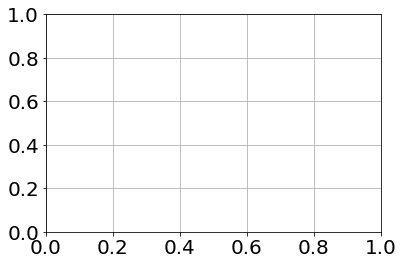

In [63]:
T = np.linspace(70, 300, (300-70))
sens = get_sens_T(213, -181988, 2309.68, -9.789, 0.014)
print(sens)
plt.plot(T, sens, label="Wav1-1 - ORMOCER")
plt.title("Sensitivity vs Temperature")
plt.xlabel("Temperature (K)")
plt.ylabel("Sensitivity (pm/K)")

In [32]:
def get_sigma_wl_q(sigmawl, sigmat, sigmawl_err, sigmat_err):
    prop_stab = (sigmawl/sigmat)*1e3
    prop_stab_err = 1e3*((sigmawl_err*sigmat - sigmat_err*sigmawl)/(sigmat**2))
    return prop_stab, prop_stab_err

In [54]:
def accuracy_model(sigmawl, sigmat, sigmawl_rh, sigmarh):
    sigma_wl = (sigmawl/sigmat)*1e3
    print(sigma_wl)
    sigma_wl_rh = ((sigmawl_rh/sigmarh)/sigmat)*1e3
    print(sigma_wl_rh)
    sigma_i4g_t = (30/sigmat)
    print(sigma_i4g_t)
    sigma_wl_t = 23
    return (sigma_wl - sigma_wl_rh - sigma_i4g_t - sigma_wl_t)

In [56]:
acc = accuracy_model(0.3, 3, 0.2, 1)
print(r"Accuracy model={0:.1f} fm/mK".format(acc))

99.99999999999999
66.66666666666667
10.0
Accuracy model=0.3 fm/mK


In [59]:
acc = accuracy_model(1.2, 3, 1.2, 1)
print(r"Accuracy model={0:.1f} fm/mK".format(acc))

399.99999999999994
399.99999999999994
10.0
Accuracy model=-33.0 fm/mK
